# Сглаживание 
\*и построение прогроза

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

Загрузим данные

In [3]:
non_stat = pd.read_csv(r"D:\TSML\1._Лекция_tsml\international-airline-passengers.csv")
stat = pd.read_csv(r"D:\TSML\1._Лекция_tsml\daily-total-female-births-in-cal.csv")

## 1. Нестационарный ряд

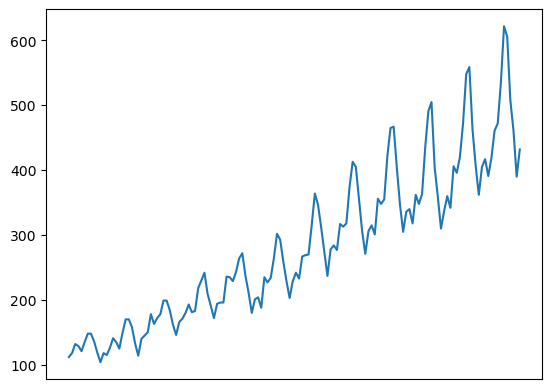

In [4]:
plt.plot(non_stat.iloc[:, 0], non_stat.iloc[:, 1])
plt.xticks([])

plt.show()

Наблюдаем тренд + сезонность => для сглаживания лучше подойдет EMA<br>
Чтобы получить прогноз дополнительно будем использовать TEMA

### EMA. Сглаживание

Взамен самописной функции будем использовать метод ```ewm```

In [5]:
non_stat['ema'] = non_stat.iloc[:, 1].ewm(alpha=0.2).mean()

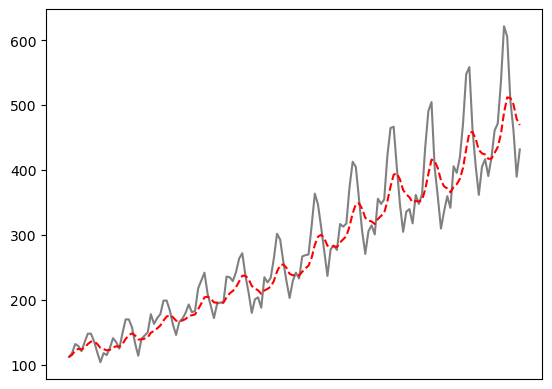

In [6]:
plt.plot(non_stat.iloc[:, 0], non_stat.iloc[:, 1], 'gray')
plt.plot(non_stat.iloc[:, 0], non_stat.ema, 'r--')
plt.xticks([])

plt.show()

### TEMA. Прогноз

Будем использовать класс из библиотеки ```statsmodels``` с встроенной оптимизацией параметров


In [7]:
size = round(0.8 * len(non_stat))

train = non_stat.iloc[:size, :]
test = non_stat.iloc[size:, :]

In [8]:
tema = ExponentialSmoothing(train.iloc[:, 1], 
                            trend='add', 
                            seasonal='add', 
                            seasonal_periods=12, 
                            damped_trend=True)
tema = tema.fit()

In [9]:
pred = tema.predict(start=test.index[0], end=test.index[-1])
pred[:5]

115    467.428063
116    401.176578
117    344.433969
118    304.887381
119    339.294194
dtype: float64

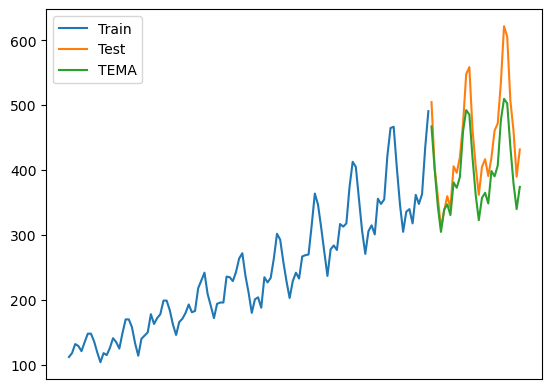

In [10]:
plt.plot(train.iloc[:, 0], train.iloc[:, 1], label='Train')
plt.plot(test.iloc[:, 0], test.iloc[:, 1], label='Test')
plt.plot(pred.index, pred, label='TEMA')
plt.legend()
plt.xticks([])

plt.show()

## 2. Стационарный ряд

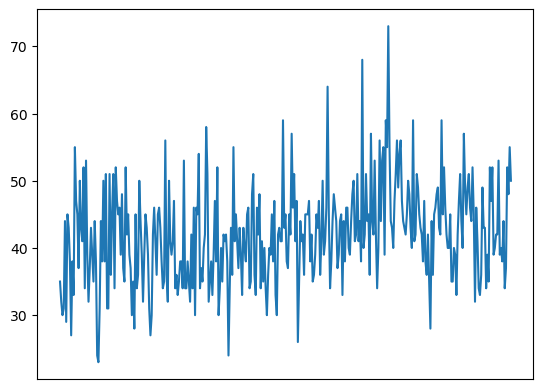

In [11]:
plt.plot(stat.iloc[:, 0], stat.iloc[:, 1])
plt.xticks([])

plt.show()

Зная, что ряд стационарный, так же выберем EMA для сглаживания.<br>
Чтобы построить прогноз, можно опять использовать EMA, поскольку ни тренда, ни сезонности в этом ряду нет.

### EMA. Сглаживание

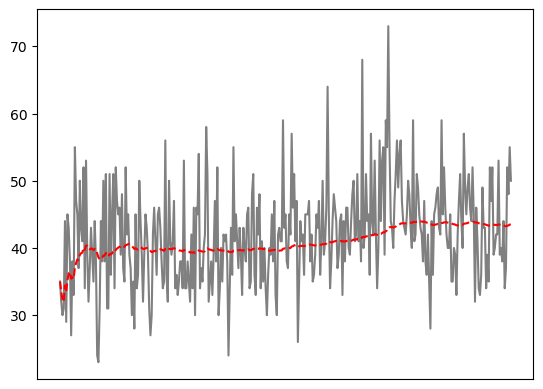

In [12]:
# уменьшим параметр альфа для оптимальной силы сглаживания

stat['ema'] = stat.iloc[:, 1].ewm(alpha=0.01).mean()

plt.plot(stat.iloc[:, 0], stat.iloc[:, 1], 'gray')
plt.plot(stat.iloc[:, 0], stat.ema, 'r--')
plt.xticks([])

plt.show()

### EMA. Прогноз

In [13]:
size = round(0.8 * len(stat))

train = stat.iloc[:size, :]
test = stat.iloc[size:, :]

In [18]:
pred = pd.Series(index=test.ema.index)
pred.loc[len(train) - 1] = alpha * train.Count.iloc[-1] + (1 - alpha) * train.ema.iloc[-1]
res = pd.Series(index=test.Count.index)
res.loc[len(train) - 1] = train.ema.iloc[-1]

for index in test.index:
    ema = alpha * pred.loc[index - 1] + (1 - alpha) * res.loc[index - 1]
    res[index] = ema
    pred[index] = ema

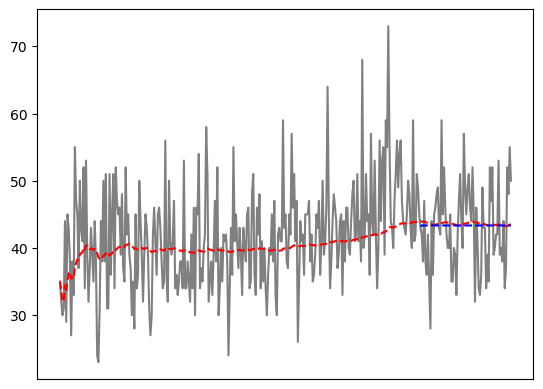

In [19]:
plt.plot(stat.iloc[:, 0], stat.iloc[:, 1], 'gray')
plt.plot(stat.ema, 'r--')
plt.plot(pred.sort_index(), 'b--')
plt.xticks([])

plt.show()